In [101]:
import warnings
warnings.filterwarnings('ignore')

import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scienceplots
import torch
import torch.nn as nn
import torchvision
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from cv2 import resize
from datetime import datetime
from gc import collect
from os import cpu_count
from scipy.io import savemat, loadmat
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

sys.path.append(f"{os.getcwd()}/ViT architecture/working ViT")
sys.path.append(f"{os.getcwd()}/scripts/")
from VisionTransformer_working import VisionTransformer as Vit_old

sys.path.append(f"{os.getcwd()}/ViT architecture/Architecture tryouts/DPT/")
from VisionTransformer_working_for_DPT import VisionTransformer as Vit
from VisionTransformer_working_for_DPT import VisionTransformer3 as Vit3

In [102]:
random_seed = 2
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [103]:
collect()
torch.cuda.empty_cache()
torch.set_printoptions(precision=6)
device = torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


## Load models

In [104]:
vit = Vit(dspl_size=104, 
          patch_size=8, 
          embed_dim=128,
          depth=4,
          n_heads=4,
          mlp_ratio=1.0,
          qkv_bias=False,
          p=0.1,
          attn_p=0.1,
          drop_path=0.).float()

path_to_vit = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/DPT/logs_and_weights/ViT-final_2023-May-16 19:56:24/ViT-final_2023-May-16 19:56:24.pth'

vit.load_state_dict(torch.load(path_to_vit, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

<All keys matched successfully>

In [217]:
pytorch_total_params = sum(p.numel() for p in vit.parameters())
print(f"Number of model parameters in ViT: {pytorch_total_params}")

Number of model parameters in ViT: 528034


In [213]:
prob_vit = Vit3(dspl_size=104, 
                patch_size=8, 
                embed_dim=128,
                depth=4,
                n_heads=4,
                mlp_ratio=1.0,
                qkv_bias=False,
                p=0.1,
                attn_p=0.1,
                drop_path=0.).float()

path_to_prob_vit = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/DPT/logs_and_weights/ViT-GNLL_final2023-May-17 23:02:08/ViT-GNLL_final2023-May-17 23:02:08.pth'

prob_vit.load_state_dict(torch.load(path_to_prob_vit, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

<All keys matched successfully>

In [214]:
pytorch_total_params = sum(p.numel() for p in prob_vit.parameters())
print(f"Number of model parameters in Prob-ViT: {pytorch_total_params}")

Number of model parameters: 528612


In [106]:
cnn = keras.models.load_model('/home/alexrichard/PycharmProjects/UQ_DL-TFM/mltfm/CNN_noisy_final-2023-May-18 23:46:36_checkpoint.h5')

In [216]:
print(f"Number of model parameters in CNN: {cnn.count_params()}")

Number of model parameters: 224572


## Load data

In [107]:
dspl_test_sets = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Test data/resolution_104/allDisplacements.h5', 'r')['dspl'])
dspl_test = np.moveaxis(np.concatenate([dspl_test_sets[i] for i in range(dspl_test_sets.shape[0])], axis=0), 3, 1)[100:200]

trac_test_sets = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Test data/resolution_104/allTractions.h5', 'r')['trac'])
trac_test = np.moveaxis(np.concatenate([trac_test_sets[i] for i in range(trac_test_sets.shape[0])], axis=0), 3, 1)[100:200]

In [116]:
var = np.mean(np.var(dspl_test, axis=(1,2,3)))
test_sets = {}
noise_sets = {}
for kappa in range(1, 11):
    test_set = np.zeros(dspl_test.shape)
    noise_set = np.zeros(dspl_test.shape)
    sigma_sq = (kappa/1000) * var
    for j in range(len(dspl_test)):
        cov = [[sigma_sq, 0],[0, sigma_sq]]
        noise = np.transpose(np.random.default_rng().multivariate_normal(mean=[0, 0], cov=cov, size=(104, 104)))
        test_set[j] = dspl_test[j] + noise
        noise_set[j] = noise
    test_sets[f'{kappa}'] = test_set
    noise_sets[f'{kappa}'] = noise_set

Export test sets to .mat files.

In [109]:
import shutil

save_files_here = '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/Artificial patch data/Raw Samples'
xx, yy = np.meshgrid(np.arange(104), np.arange(104), indexing='ij')
pos = np.vstack([xx.reshape(-1), yy.reshape(-1)], dtype=np.double).T
for i in range(1, 11):
    path_to_dir = f'{save_files_here}/{i}'
    if os.path.exists(path_to_dir):
        shutil.rmtree(path_to_dir)
    os.makedirs(path_to_dir)
    for j, sample in enumerate(test_sets[f'{i}']):
        file_name = f'{path_to_dir}/test_sample_{j + 1}.mat'
        vec_dspl = np.vstack([sample[0].reshape(-1), sample[1].reshape(-1)], dtype=np.double).T
        vec_noise = np.vstack([noise_sets[f'{i}'][j, 0].reshape(-1), noise_sets[f'{i}'][j, 1].reshape(-1)], dtype=np.double).T
        mdict = {'input_data': {'noise': [{'vec': vec_noise, 'pos': pos}, {'vec': vec_noise, 'pos': pos}], 'displacement': [{'vec': vec_dspl, 'pos': pos}, {'vec': vec_dspl, 'pos': pos}]}}
        savemat(file_name, mdict=mdict)

Load BFFTC predictions for each test set.

In [118]:
bfftc_prediction_sets = {}
bfftc_displacement_sets = {}

directory = "/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/Artificial patch data/Predictions"
    
for i, _ in enumerate(os.listdir(directory), 1):
    bfftc_prediction = np.zeros((dspl_test.shape[0], 2, 102, 102))
    bfftc_displacement = np.zeros((dspl_test.shape[0], 2, 102, 102))
    for j, file in enumerate(os.listdir(f'{directory}/{i}')):
        filename = os.fsdecode(file)
        if filename.endswith(".mat"):
            bfft_pred = loadmat(f'{directory}/{i}/{filename}')['TFM_results']['traction'][0][0].T.reshape((2, 102, 102), order='F')
            bfft_dspl = loadmat(f'{directory}/{i}/{filename}')['TFM_results']['displacement'][0][0].T.reshape((2, 102, 102), order='F')
            bfftc_prediction[j] = bfft_pred
            bfftc_displacement[j] = bfft_dspl
    bfftc_prediction_sets[f'{i}'] = bfftc_prediction
    bfftc_displacement_sets[f'{i}'] = bfftc_displacement

Find correct samples in test set and remove outer rims.

In [120]:
bfftc_prediction_sets_trimmed = {}
noisy_X_test_sets = {}
ground_truths_trimmed = torch.zeros((test_sets['1'].shape[0], 3, 98, 98))

for num, pred in tqdm(bfftc_prediction_sets.items()):
    bfftc_prediction_set_trimmed = torch.zeros((test_sets[num].shape[0], test_sets[num].shape[1], 98, 98))
    X_test_noisy = torch.zeros(test_sets[num].shape)
    for i, sample in enumerate(bfftc_displacement_sets[num]):
        for j, dspl in enumerate(torch.tensor(test_sets[num])):
            if torch.allclose(dspl[:, 1:103, 1:103].float(), torch.tensor(sample).float(), atol=1e-02, rtol=1):
                bfftc_prediction_set_trimmed[i] = torch.tensor(bfftc_prediction_sets[num][i, :, 3:101, 3:101]).float()
                if num == '1':
                    ground_truths_trimmed[i] = torch.tensor(trac_test[j, :, 3:101, 3:101]).float()
                X_test_noisy[i] = dspl.float()
    bfftc_prediction_sets_trimmed[num] = bfftc_prediction_set_trimmed
    # ground_truth_sets_trimmed[num] = ground_truths_trimmed
    noisy_X_test_sets[num] = X_test_noisy

100%|████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.90s/it]


## Evaluation

In [121]:
def mse_for_noise_level(vit_pred,
                        prob_vit_pred,
                        cnn_pred, 
                        bfftc_pred, 
                        ground_truth):
    
    mse = torch.nn.MSELoss(reduction='none')
    vit_mse = torch.mean(mse(vit_pred[:, :, 3:101, 3:101], ground_truth[:, 0:2]))
    prob_vit_mse = torch.mean(mse(prob_vit_pred[:, :, 3:101, 3:101], ground_truth[:, 0:2]))
    cnn_mse = torch.mean(mse(torch.tensor(np.moveaxis(cnn_pred, 3, 1)[:, :, 3:101, 3:101]), ground_truth[:, 0:2]))
    bfftc_mse = torch.mean(mse(bfftc_pred, ground_truth[:, 0:2]))
    
    return vit_mse, prob_vit_mse, cnn_mse, bfftc_mse

In [122]:
def adtma_for_noise_level(appended_vit_pred, 
                          appended_vit_target,
                          appended_prob_vit_pred,
                          appended_prob_vit_target,
                          appended_cnn_pred, 
                          appended_cnn_target, 
                          appended_bfftc_pred, 
                          appended_bfftc_target):
    
    vit_adtma = adtma(appended_vit_pred, appended_vit_target, device, False)
    prob_vit_adtma = adtma(appended_prob_vit_pred, appended_prob_vit_target, device, False)
    cnn_adtma = adtma(appended_cnn_pred, appended_cnn_target, device, False)
    bfftc_adtma = adtma(appended_bfftc_pred, appended_bfftc_target, device, False)
    
    return vit_adtma, prob_vit_adtma, cnn_adtma, bfftc_adtma

In [123]:
def csta_for_noise_level(appended_vit_pred,
                         appended_vit_target,
                         appended_prob_vit_pred,
                         appended_prob_vit_target,
                         appended_cnn_pred,
                         appended_cnn_target,
                         appended_bfftc_pred, 
                         appended_bfftc_target):
    
    vit_csta = csta(appended_vit_pred, appended_vit_target, device, False)
    prob_vit_csta = csta(appended_prob_vit_pred, appended_vit_target, device, False)
    cnn_cos_sim = csta(appended_cnn_pred, appended_cnn_target, device, False)
    bfftc_cos_sim = csta(appended_bfftc_pred, appended_bfftc_target, device, False)
    
    return vit_csta, prob_vit_csta, cnn_cos_sim, bfftc_cos_sim

In [124]:
def dma_for_noise_level(appended_vit_pred,
                        appended_vit_target,
                        appended_prob_vit_pred,
                        appended_prob_vit_target, 
                        appended_cnn_pred, 
                        appended_cnn_target, 
                        appended_bfftc_pred, 
                        appended_bfftc_target,
                        ground_truth):
    
    vit_dma = dma(ground_truth, appended_vit_pred, appended_vit_target, device, False)
    prob_vit_dma = dma(ground_truth, appended_prob_vit_pred, appended_prob_vit_target, device, False)
    cnn_dma = dma(ground_truth, appended_cnn_pred, appended_cnn_target, device, False)
    bfftc_dma = dma(ground_truth, appended_bfftc_pred, appended_bfftc_target, device, False)
    
    return vit_dma, prob_vit_dma, cnn_dma, bfftc_dma

In [125]:
def dtmb_for_noise_level(vit_pred,
                         appended_vit_target,
                         prob_vit_pred,
                         appended_prob_vit_target,
                         cnn_pred,
                         appended_cnn_target,
                         bfftc_pred,
                         appended_bfftc_target,
                         ground_truth):
    
    vit_dtmb = dtmb(vit_pred[:, :, 3:101, 3:101], ground_truth, appended_vit_target, device, False)
    prob_vit_dtmb = dtmb(prob_vit_pred[:, :, 3:101, 3:101], ground_truth, appended_prob_vit_target, device, False)
    cnn_dtmb = dtmb(torch.tensor(np.moveaxis(cnn_pred, 3, 1))[:, :, 3:101, 3:101], ground_truth, appended_cnn_target, device, False)
    bfftc_dtmb = dtmb(bfftc_pred, ground_truth, appended_bfftc_target, device, False)

    return vit_dtmb, prob_vit_dtmb, cnn_dtmb, bfftc_dtmb

In [126]:
def snr_for_noise_level(vit_pred, 
                        appended_vit_target,
                        prob_vit_pred,
                        appended_prob_vit_target,
                        cnn_pred, 
                        appended_cnn_target, 
                        bfftc_pred, 
                        appended_bfftc_target,
                        ground_truth):
    
    vit_snr = snr(vit_pred[:, :, 3:101, 3:101], ground_truth, appended_vit_target, device, False)
    prob_vit_snr = snr(prob_vit_pred[:, :, 3:101, 3:101], ground_truth, appended_prob_vit_target, device, False)
    cnn_snr = snr(torch.tensor(np.moveaxis(cnn_pred, 3, 1))[:, :, 3:101, 3:101], ground_truth, appended_cnn_target, device, False)
    bfftc_snr = snr(bfftc_pred, ground_truth, appended_bfftc_target, device, False)
    
    return vit_snr, prob_vit_snr, cnn_snr, bfftc_snr

In [127]:
noise_levels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
metrics = ['mse', 'adtma', 'csta', 'dma', 'dtmb', 'snr']

vit_mses = []
prob_vit_mses = []
cnn_mses = []
bfftc_mses = []

vit_adtmas = []
prob_vit_adtmas = []
cnn_adtmas = []
bfftc_adtmas = []

vit_cstas = []
prob_vit_cstas = []
cnn_cstas = []
bfftc_cstas = []

vit_dmas = []
prob_vit_dmas = []
cnn_dmas = []
bfftc_dmas = []

vit_dtmbs = []
prob_vit_dtmbs = []
cnn_dtmbs = []
bfftc_dtmbs = []

vit_snrs = []
prob_vit_snrs = []
cnn_snrs = []
bfftc_snrs = []

In [128]:
from MultiTask import append_predictions_and_targets, adtma, csta, dma, dtma, dtmb, snr

for noise_level in tqdm(noise_levels):
    vit.eval()
    prob_vit.eval()
    vit_pred = vit(noisy_X_test_sets[noise_level])
    prob_vit_pred = prob_vit(noisy_X_test_sets[noise_level])[:, 0:2]
    cnn_pred = cnn.predict(np.moveaxis(np.array(noisy_X_test_sets[noise_level]), 1, 3))

    appended_vit_pred, appended_vit_target = append_predictions_and_targets(vit_pred[:, :, 3:101, 3:101], ground_truths_trimmed, device)
    appended_prob_vit_pred, appended_prob_vit_target = append_predictions_and_targets(prob_vit_pred[:, :, 3:101, 3:101], ground_truths_trimmed, device)
    appended_cnn_pred, appended_cnn_target = append_predictions_and_targets(torch.tensor(np.moveaxis(cnn_pred, 3, 1))[:, :, 3:101, 3:101], ground_truths_trimmed, device)
    appended_bfftc_pred, appended_bfftc_target = append_predictions_and_targets(bfftc_prediction_sets_trimmed[noise_level], ground_truths_trimmed, device)
    
    # mse
    vit_mse, prob_vit_mse, cnn_mse, bfftc_mse = mse_for_noise_level(vit_pred,
                                                                    prob_vit_pred,
                                                                    cnn_pred, 
                                                                    bfftc_prediction_sets_trimmed[noise_level],
                                                                    ground_truths_trimmed)
    vit_mses.append(vit_mse.detach())
    prob_vit_mses.append(prob_vit_mse.detach())
    cnn_mses.append(cnn_mse.detach())
    bfftc_mses.append(bfftc_mse.detach())
    
    # adtma
    vit_adtma, prob_vit_adtma, cnn_adtma, bfftc_adtma = adtma_for_noise_level(appended_vit_pred, 
                                                              appended_vit_target,
                                                              appended_prob_vit_pred,
                                                              appended_prob_vit_target,
                                                              appended_cnn_pred, 
                                                              appended_cnn_target, 
                                                              appended_bfftc_pred, 
                                                              appended_bfftc_target)
    
    vit_adtmas.append(vit_adtma.detach())
    prob_vit_adtmas.append(prob_vit_adtma.detach())
    cnn_adtmas.append(cnn_adtma.detach())
    bfftc_adtmas.append(bfftc_adtma.detach())
    
    # csta
    vit_csta, prob_vit_csta, cnn_csta, bfftc_csta = csta_for_noise_level(appended_vit_pred,
                                                                         appended_vit_target,
                                                                         appended_prob_vit_pred,
                                                                         appended_prob_vit_target,
                                                                         appended_cnn_pred,
                                                                         appended_cnn_target,
                                                                         appended_bfftc_pred, 
                                                                         appended_bfftc_target)
    vit_cstas.append(vit_csta.detach())
    prob_vit_cstas.append(prob_vit_csta.detach())
    cnn_cstas.append(cnn_csta.detach())
    bfftc_cstas.append(bfftc_csta.detach())
    
    # dma
    vit_dma, prob_vit_dma, cnn_dma, bfftc_dma = dma_for_noise_level(appended_vit_pred,
                                                                    appended_vit_target,
                                                                    appended_prob_vit_pred,
                                                                    appended_prob_vit_target, 
                                                                    appended_cnn_pred, 
                                                                    appended_cnn_target, 
                                                                    appended_bfftc_pred, 
                                                                    appended_bfftc_target,
                                                                    ground_truths_trimmed)
    vit_dmas.append(vit_dma.detach())
    prob_vit_dmas.append(prob_vit_dma.detach())
    cnn_dmas.append(cnn_dma.detach())
    bfftc_dmas.append(bfftc_dma.detach())
    
    # dtmb
    vit_dtmb, prob_vit_dtmb, cnn_dtmb, bfftc_dtmb = dtmb_for_noise_level(vit_pred,
                                                                         appended_vit_target,
                                                                         prob_vit_pred,
                                                                         appended_prob_vit_target,
                                                                         cnn_pred,
                                                                         appended_cnn_target,
                                                                         bfftc_prediction_sets_trimmed[noise_level],
                                                                         appended_bfftc_target,
                                                                         ground_truths_trimmed)
    vit_dtmbs.append(vit_dtmb.detach())
    prob_vit_dtmbs.append(prob_vit_dtmb.detach())
    cnn_dtmbs.append(cnn_dtmb.detach())
    bfftc_dtmbs.append(bfftc_dtmb.detach())

    # snr
    vit_snr, prob_vit_snr, cnn_snr, bfftc_snr = snr_for_noise_level(vit_pred, 
                                                                    appended_vit_target,
                                                                    prob_vit_pred,
                                                                    appended_prob_vit_target,
                                                                    cnn_pred, 
                                                                    appended_cnn_target, 
                                                                    bfftc_prediction_sets_trimmed[noise_level], 
                                                                    appended_bfftc_target,
                                                                    ground_truths_trimmed)
    vit_snrs.append(vit_snr.detach())
    prob_vit_snrs.append(prob_vit_snr.detach())
    cnn_snrs.append(cnn_snr.detach())
    bfftc_snrs.append(bfftc_snr.detach())

  0%|                                                                         | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 0s 38ms/step


 10%|██████▍                                                         | 1/10 [03:26<30:55, 206.21s/it]

4/4 [==============================] - 0s 35ms/step


 20%|████████████▊                                                   | 2/10 [06:48<27:09, 203.71s/it]

4/4 [==============================] - 0s 38ms/step


 30%|███████████████████▏                                            | 3/10 [10:09<23:39, 202.80s/it]

4/4 [==============================] - 0s 37ms/step


 40%|█████████████████████████▌                                      | 4/10 [13:30<20:12, 202.09s/it]

4/4 [==============================] - 0s 37ms/step


 50%|████████████████████████████████                                | 5/10 [16:55<16:55, 203.07s/it]

4/4 [==============================] - 0s 39ms/step


 60%|██████████████████████████████████████▍                         | 6/10 [20:18<13:31, 202.94s/it]

4/4 [==============================] - 0s 35ms/step


 70%|████████████████████████████████████████████▊                   | 7/10 [23:40<10:07, 202.58s/it]

4/4 [==============================] - 0s 36ms/step


 80%|███████████████████████████████████████████████████▏            | 8/10 [27:03<06:45, 202.66s/it]

4/4 [==============================] - 0s 35ms/step


 90%|█████████████████████████████████████████████████████████▌      | 9/10 [30:24<03:22, 202.39s/it]

4/4 [==============================] - 0s 39ms/step


100%|███████████████████████████████████████████████████████████████| 10/10 [33:47<00:00, 202.72s/it]


## Plots

In [129]:
kappas = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

<IPython.core.display.Javascript object>


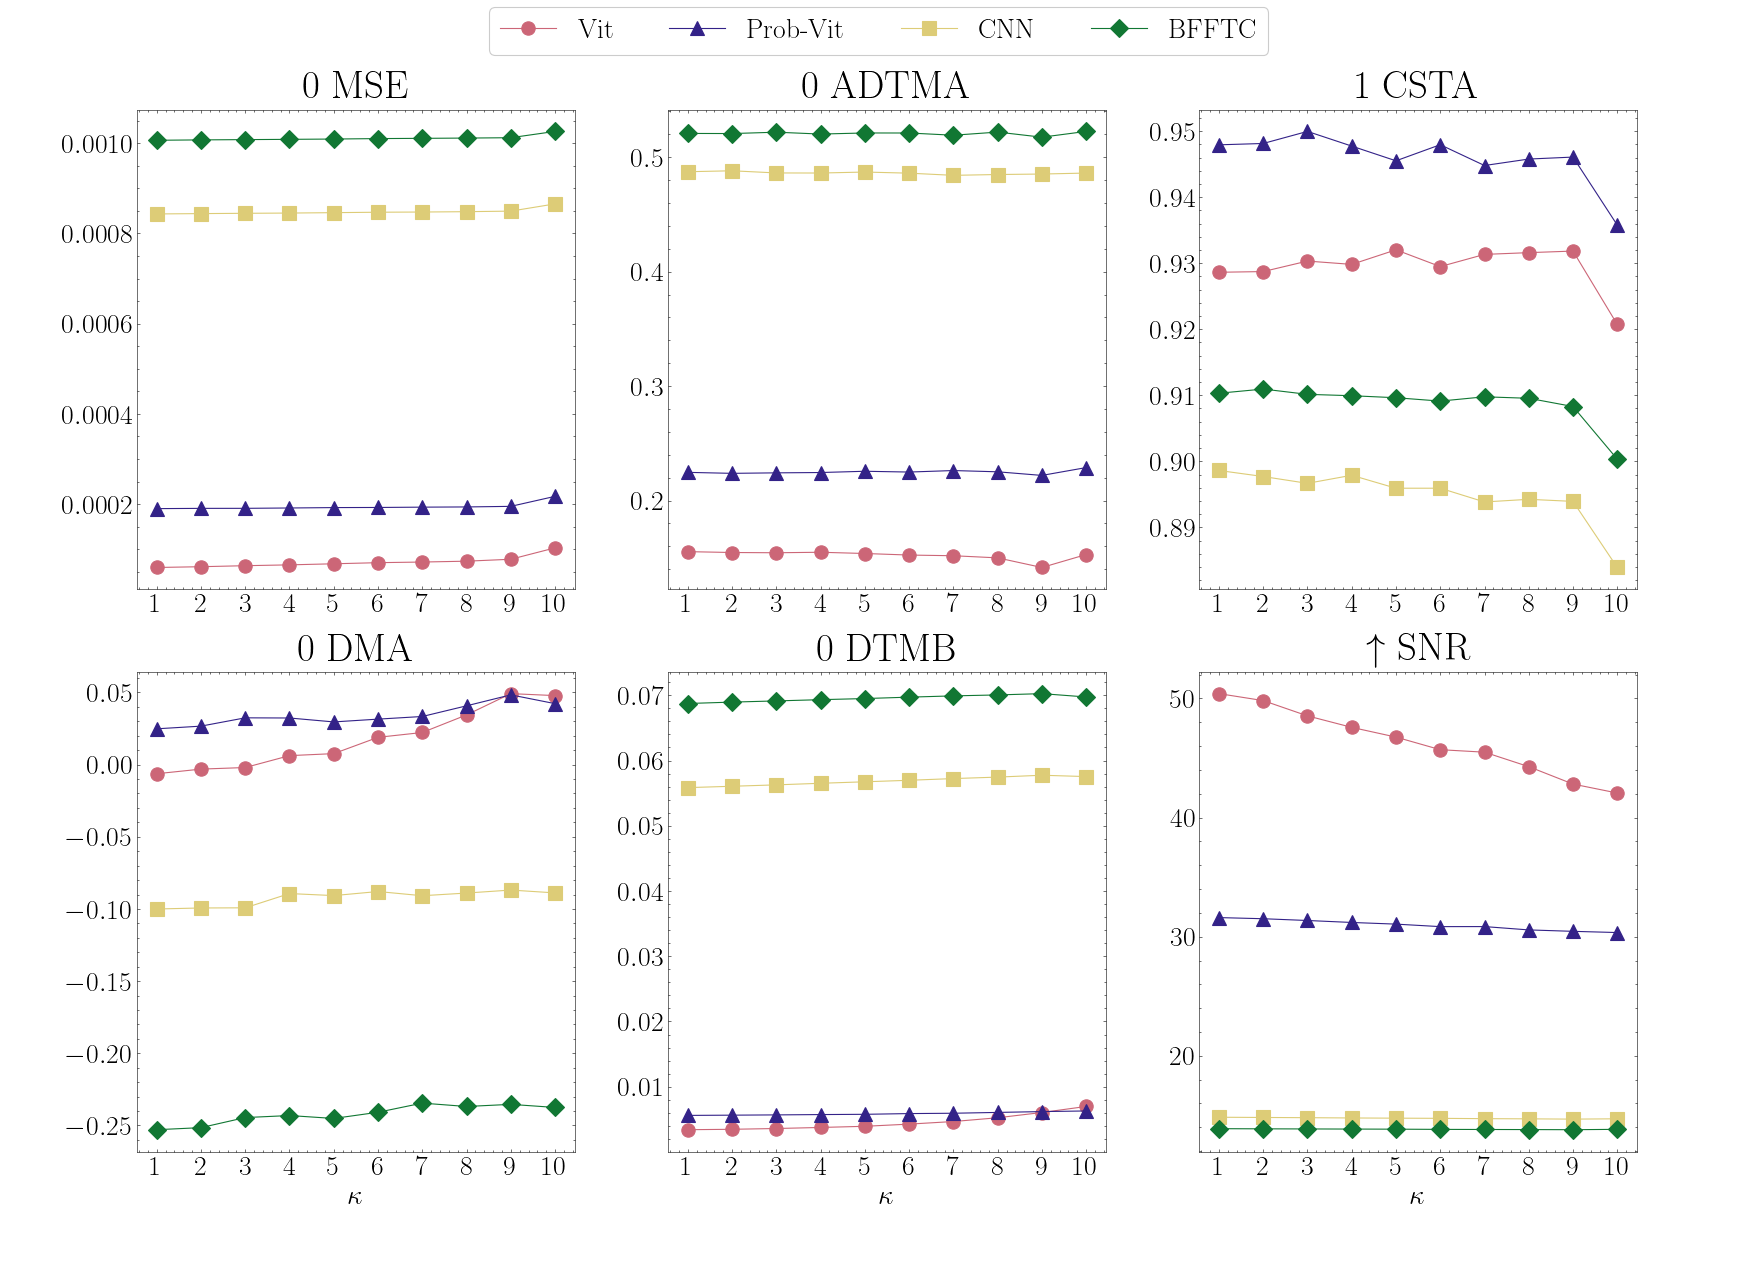

In [133]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 3, figsize=(22, 16))
fig.tight_layout(pad=9, w_pad=3, h_pad=4)

axs[0, 0].plot(kappas, [mse.detach().numpy() for mse in vit_mses], 'o-', label='Vit', markersize=12)
axs[0, 0].plot(kappas, [mse.detach().numpy() for mse in prob_vit_mses], '^-', label='Prob-Vit', markersize=12)
axs[0, 0].plot(kappas, [mse.detach().numpy() for mse in cnn_mses], 's-', label='CNN', markersize=12)
axs[0, 0].plot(kappas, [mse.detach().numpy() for mse in bfftc_mses], 'D-', label='BFFTC', markersize=12)
axs[0, 0].set_facecolor('white')
axs[0, 0].grid(color='white', linestyle='-', linewidth=1)
axs[0, 0].set_title('0  MSE', pad=10, fontsize=35)

axs[0, 1].plot(kappas, [adtma.detach().numpy() for adtma in vit_adtmas], 'o-', label='Vit', markersize=12)
axs[0, 1].plot(kappas, [adtma.detach().numpy() for adtma in prob_vit_adtmas], '^-', label='Prob-Vit', markersize=12)
axs[0, 1].plot(kappas, [adtma.detach().numpy() for adtma in cnn_adtmas], 's-', label='CNN', markersize=12)
axs[0, 1].plot(kappas, [adtma.detach().numpy() for adtma in bfftc_adtmas], 'D-', label='BFFTC', markersize=12)
axs[0, 1].set_facecolor('white')
axs[0, 1].grid(color='white', linestyle='-', linewidth=1)
axs[0, 1].set_title('0  ADTMA', pad=10, fontsize=35)

axs[0, 2].plot(kappas, [csta.detach().numpy() for csta in vit_cstas], 'o-', label='Vit', markersize=12)
axs[0, 2].plot(kappas, [csta.detach().numpy() for csta in prob_vit_cstas], '^-', label='Prob-Vit', markersize=12)
axs[0, 2].plot(kappas, [csta.detach().numpy() for csta in cnn_cstas], 's-', label='CNN', markersize=12)
axs[0, 2].plot(kappas, [csta.detach().numpy() for csta in bfftc_cstas], 'D-', label='BFFTC', markersize=12)
axs[0, 2].set_facecolor('white')
axs[0, 2].grid(color='white', linestyle='-', linewidth=1)
axs[0, 2].set_title('1  CSTA', pad=10, fontsize=35)

axs[1, 0].plot(kappas, [dma.detach().numpy() for dma in vit_dmas], 'o-', label='Vit', markersize=12)
axs[1, 0].plot(kappas, [dma.detach().numpy() for dma in prob_vit_dmas], '^-', label='Prob-Vit', markersize=12)
axs[1, 0].plot(kappas, [dma.detach().numpy() for dma in cnn_dmas], 's-', label='CNN', markersize=12)
axs[1, 0].plot(kappas, [dma.detach().numpy() for dma in bfftc_dmas], 'D-', label='BFFTC', markersize=12)
axs[1, 0].set_facecolor('white')
axs[1, 0].grid(color='white', linestyle='-', linewidth=1)
axs[1, 0].set_xlabel(r'$\mathit{\kappa}$', fontsize=25)
axs[1, 0].set_title('0  DMA', pad=10, fontsize=35)

axs[1, 1].plot(kappas, [dtmb.detach().numpy() for dtmb in vit_dtmbs], 'o-', label='Vit', markersize=12)
axs[1, 1].plot(kappas, [dtmb.detach().numpy() for dtmb in prob_vit_dtmbs], '^-', label='Prob-Vit', markersize=12)
axs[1, 1].plot(kappas, [dtmb.detach().numpy() for dtmb in cnn_dtmbs], 's-', label='CNN', markersize=12)
axs[1, 1].plot(kappas, [dtmb.detach().numpy() for dtmb in bfftc_dtmbs], 'D-', label='BFFTC', markersize=12)
axs[1, 1].set_facecolor('white')
axs[1, 1].grid(color='white', linestyle='-', linewidth=1)
axs[1, 1].set_xlabel(r'$\mathit{\kappa}$', fontsize=25)
axs[1, 1].set_title('0  DTMB', pad=10, fontsize=35)

axs[1, 2].plot(kappas, [snr.detach().numpy() for snr in vit_snrs], 'o-', label='Vit', markersize=12)
axs[1, 2].plot(kappas, [snr.detach().numpy() for snr in prob_vit_snrs], '^-', label='Prob-Vit', markersize=12)
axs[1, 2].plot(kappas, [snr.detach().numpy() for snr in cnn_snrs], 's-', label='CNN', markersize=12)
axs[1, 2].plot(kappas, [snr.detach().numpy() for snr in bfftc_snrs], 'D-', label='BFFTC', markersize=12)
axs[1, 2].set_facecolor('white')
axs[1, 2].grid(color='white', linestyle='-', linewidth=1)
axs[1, 2].set_xlabel(r'$\mathit{\kappa}$', fontsize=25)
axs[1, 2].set_title(r'$\uparrow$ SNR', pad=10, fontsize=35)

line, label = axs[0, 0].get_legend_handles_labels()
fig.legend(line, label, fontsize=25, ncols=4, bbox_to_anchor=(0.27, 1.005), loc='upper left')

image_name = 'All_metrics_kappa_final.svg'
fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='svg', dpi=100)

In [150]:
avg_test_mse_vit = torch.mean(torch.tensor(vit_mses))
avg_test_mse_cnn = torch.mean(torch.tensor(cnn_mses))
print(f'average mse reduction of ViT compared to CNN: {1 - avg_test_mse_vit / avg_test_mse_cnn}')

average mse reduction of ViT compared to CNN: 0.9156153202056885


In [151]:
avg_test_mse_bfftc = torch.mean(torch.tensor(bfftc_mses))
print(f'average mse reduction of ViT compared to BFFTC: {1 - avg_test_mse_vit / avg_test_mse_bfftc}')

average mse reduction of ViT compared to BFFTC: 0.9292147159576416


Graphical representation of test sample

In [142]:
vit.eval()
prob_vit.eval()

VisionTransformer3(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(2, 128, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((128,), eps=1e-07, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=128, out_features=384, bias=False)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((128,), eps=1e-07, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=128, out_features=128, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=128, out_features=128, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
    )
    (1): Block(
      (norm1): LayerNorm((128,), eps=1e-07, elementwise_affine=True)
      (attn): Attenti

<IPython.core.display.Javascript object>


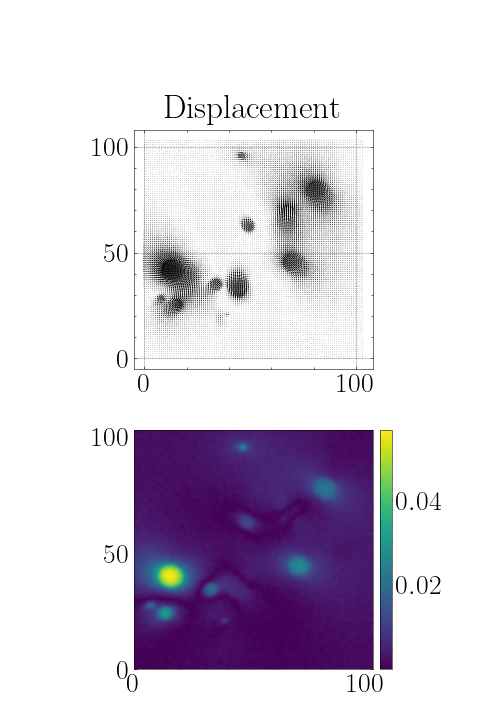

In [143]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

axs[0].quiver(noisy_X_test_sets['5'][0, 0, :, :].detach().numpy(), noisy_X_test_sets['5'][0, 1, :, :].detach().numpy(), scale=1)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title('Displacement', pad=10, fontsize=30)

C = np.sqrt(noisy_X_test_sets['5'][0, 0, :, :].detach().numpy() ** 2 + noisy_X_test_sets['5'][0, 0, :, :].detach().numpy() ** 2)
im = axs[1].pcolormesh(C, shading='gouraud')
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.82)

image_name = 'Artificial_dspl.jpeg'
fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

In [144]:
norm = matplotlib.colors.Normalize(vmin=0.0, 
                                   vmax=2 * np.max(bfftc_prediction_sets_trimmed['5'][0, 0, :, :].detach().numpy() ** 2 + bfftc_prediction_sets_trimmed['5'][0, 1, :, :].detach().numpy() ** 2))

<IPython.core.display.Javascript object>


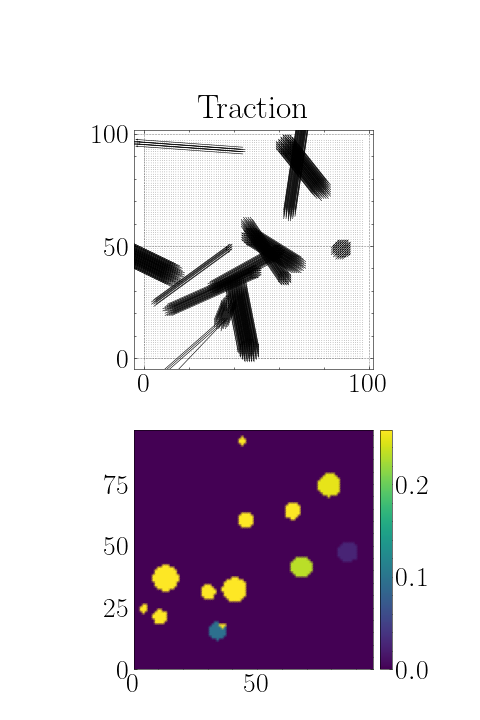

In [145]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

axs[0].quiver(ground_truths_trimmed[0, 0, :, :].detach().numpy(), ground_truths_trimmed[0, 1, :, :].detach().numpy(), scale=1)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title('Traction', pad=10, fontsize=30)

C = np.sqrt(ground_truths_trimmed[0, 0, :, :].detach().numpy() ** 2 + ground_truths_trimmed[0, 1, :, :].detach().numpy() ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.82)

image_name = 'Artificial_trac.jpeg'
fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

<IPython.core.display.Javascript object>


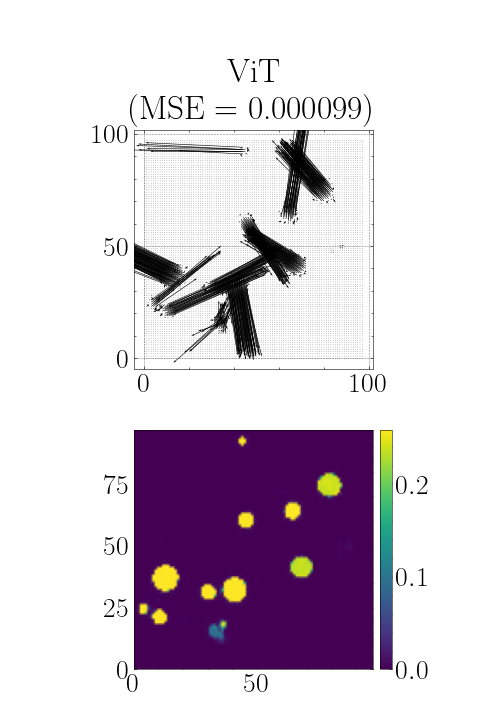

In [146]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

vit_pred = vit(noisy_X_test_sets['5'][0].unsqueeze(0))
err = mse(vit_pred[:, :, 3:101, 3:101], ground_truths_trimmed[0, 0:2, :, :])

axs[0].quiver(vit_pred[0, 0, 3:101, 3:101].detach().numpy(), vit_pred[0, 1, 3:101, 3:101].detach().numpy(), scale=1)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title(f'ViT \n (MSE ={err:9.6f})', pad=10, fontsize=30)

C = np.sqrt(vit_pred[0, 0, 3:101, 3:101].detach().numpy() ** 2 + vit_pred[0, 1, 3:101, 3:101].detach().numpy() ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.82)

image_name = 'Artificial_vit.jpeg'
fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

<IPython.core.display.Javascript object>


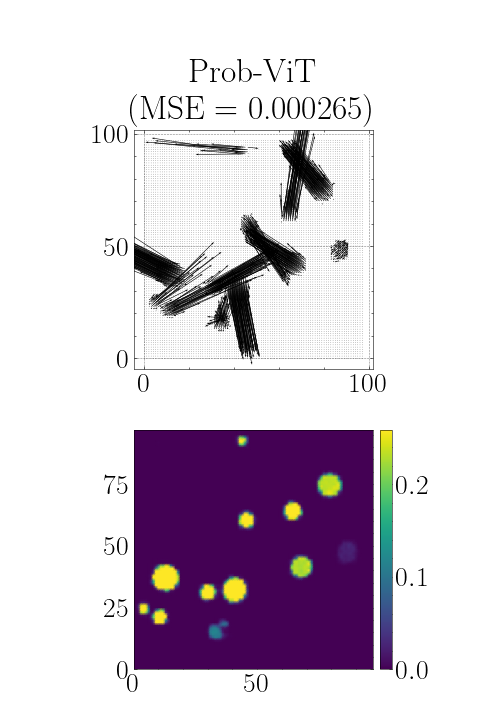

In [147]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

prob_vit_pred = prob_vit(noisy_X_test_sets['5'][0].unsqueeze(0))
err = mse(prob_vit_pred[:, 0:2, 3:101, 3:101], ground_truths_trimmed[0, 0:2, :, :])

axs[0].quiver(prob_vit_pred[0, 0, 3:101, 3:101].detach().numpy(), prob_vit_pred[0, 1, 3:101, 3:101].detach().numpy(), scale=1)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title(f'Prob-ViT \n (MSE ={err:9.6f})', pad=10, fontsize=30)

C = np.sqrt(prob_vit_pred[0, 0, 3:101, 3:101].detach().numpy() ** 2 + prob_vit_pred[0, 1, 3:101, 3:101].detach().numpy() ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.82)

image_name = 'Artificial_prob-vit.jpeg'
fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

<IPython.core.display.Javascript object>


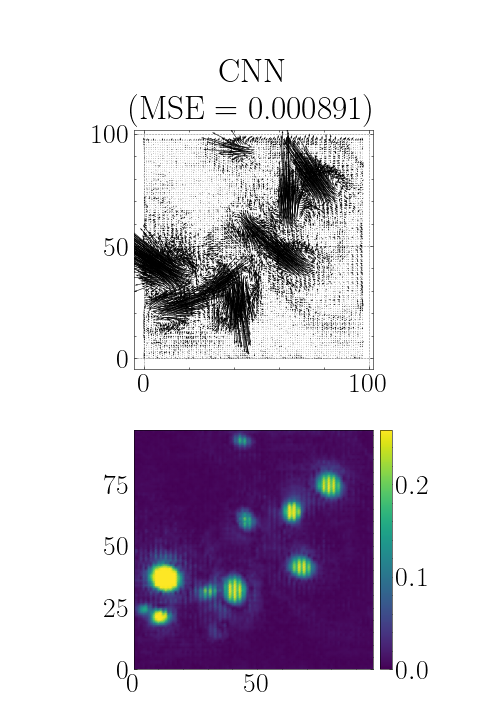

In [148]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

cnn_pred = cnn(np.moveaxis(np.array(noisy_X_test_sets['5'][0].unsqueeze(0)), 1, 3))
err = mse(torch.tensor(np.moveaxis(cnn_pred[:, 3:101, 3:101, :], 3, 1)).float(), ground_truths_trimmed[0, 0:2, :, :])

axs[0].quiver(cnn_pred[0, 3:101, 3:101, 0], cnn_pred[0, 3:101, 3:101, 1], scale=1)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title(f'CNN \n (MSE ={err:9.6f})', pad=10, fontsize=30)

C = np.sqrt(cnn_pred[0, 3:101, 3:101, 0] ** 2 + cnn_pred[0, 3:101, 3:101, 1] ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.82)

image_name = 'Artificial_cnn.jpeg'
fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

<IPython.core.display.Javascript object>


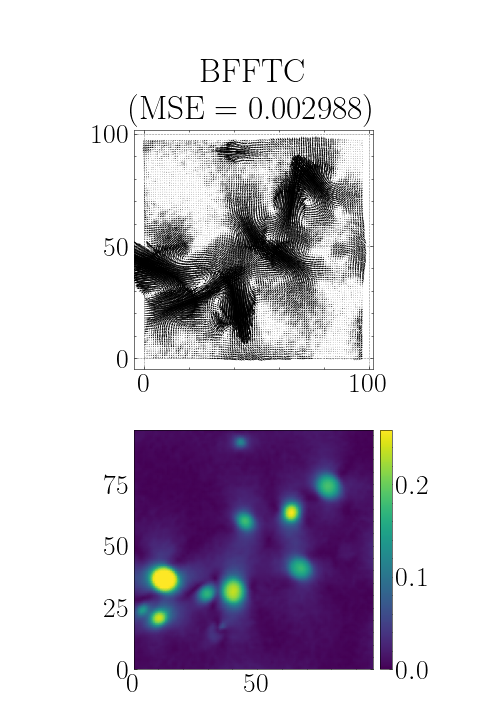

In [210]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

err = mse(bfftc_prediction_sets_trimmed['5'][0, 0, :, :], ground_truths_trimmed[0, 0:2, :, :])

axs[0].quiver(bfftc_prediction_sets_trimmed['5'][0, 0, :, :].detach().numpy(), bfftc_prediction_sets_trimmed['5'][0, 1, :, :].detach().numpy(), scale=1)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title(f'BFFTC \n (MSE ={err:9.6f})', pad=10, fontsize=30)

C = np.sqrt(bfftc_prediction_sets_trimmed['5'][0, 0, :, :].detach().numpy() ** 2 + bfftc_prediction_sets_trimmed['5'][0, 1, :, :].detach().numpy() ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.82)

image_name = 'Artificial_bfftc.jpeg'
#fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

<IPython.core.display.Javascript object>


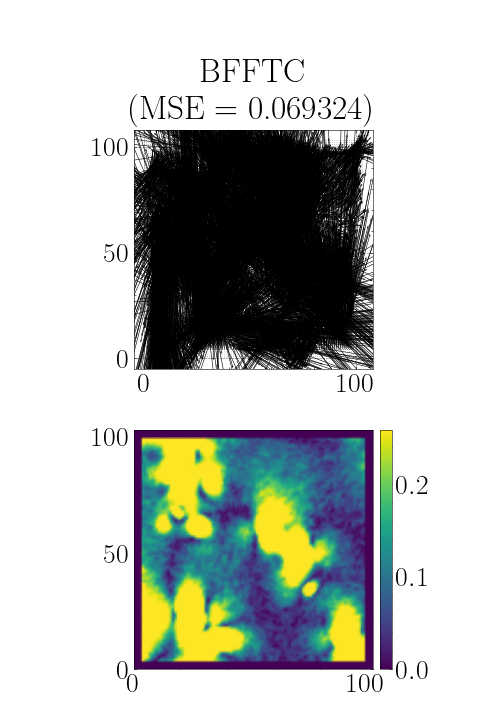

In [187]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

err = mse(TFM_results_padded[0, 3:101, 3:101], ground_truths_trimmed[0, 0:2, :, :])

axs[0].quiver(TFM_results_padded[0, :, :].detach().numpy(), TFM_results_padded[1, :, :].detach().numpy(), scale=1)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title(f'BFFTC \n (MSE ={err:9.6f})', pad=10, fontsize=30)

C = np.sqrt(TFM_results_padded[0, :, :].detach().numpy() ** 2 + TFM_results_padded[1, :, :].detach().numpy() ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.82)

image_name = 'Artificial_bfftc.jpeg'
#fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)